In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 200
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])

        pop = new_pop
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    r = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,1000),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        D = np.linalg.norm(Uto-Uf)**2
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Uto, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        rho_vector[0][t] = pt[0][0]
        rho_vector[1][t] = pt[0][1]
        rho_vector[2][t] = pt[1][0]
        rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
        u[0] = resultado_algoritmo_genetico[0]
        u[1] = resultado_algoritmo_genetico[1]
        u[2] = resultado_algoritmo_genetico[2]
        aas.append((u[0],u[1],u[2]))
        print(f"Distância: {distance_vector[-1]}")
        print(f"Fidelidade: {fid_vector[-1]}")
        print(f"Fidelidade da porta: {fid_autores[-1]}")
        t += 1
        Ut = Uto
        

    print(f"O rho gerado foi: {pt}") 
    print(f"A matriz de evolução Ut gerada foi: {Ut}")
    print(f"Portanto, a distância gerada foi: {D}")
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal
Distância: 7.929960672888765
Fidelidade: (0.5042478466284487-1.8078903405427336e-09j)
Fidelidade da porta: 0.3275986837092666
Distância: 6.918379472092127
Fidelidade: (0.5716372231563115-6.852678157233086e-10j)
Fidelidade da porta: 0.26752465197191644
Distância: 4.997649243773367
Fidelidade: (0.6802725970850254-6.498102153787078e-09j)
Fidelidade da porta: 0.2706900791167463
Distância: 2.768069949255776
Fidelidade: (0.8207674666703659-1.2604773680894872e-08j)
Fidelidade da porta: 0.46698317040853016
Distância: 0.9292096623636629
Fidelidade: (0.9392894477986954+3.719205977925605e-09j)
Fidelidade da porta: 0.7845300080176072
Distância: 0.2440614216392343
Fidelidade: (0.9839199621519377+1.9606436233687637e-09j)
Fidelidade da porta: 0.9416466466922113
Distância: 0.0743011024396211
Fidelidade: (0.9945814380333109+1.7097265061054366e-09j)
Fidelidade da porta: 0.9833279855596097
Distância: 0.025712787673524844
Fidelidade: (0.9984101896892116+8.419891020994336e-10j)


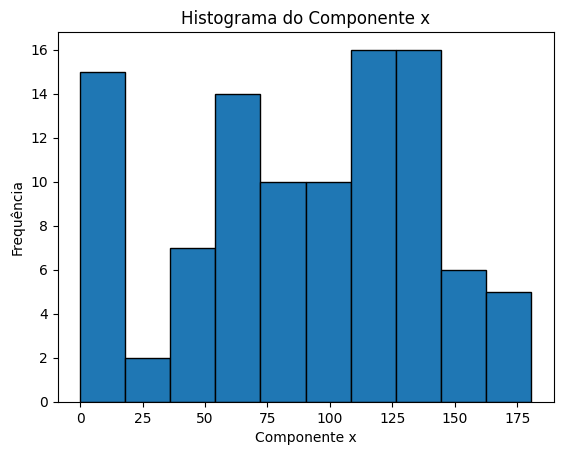

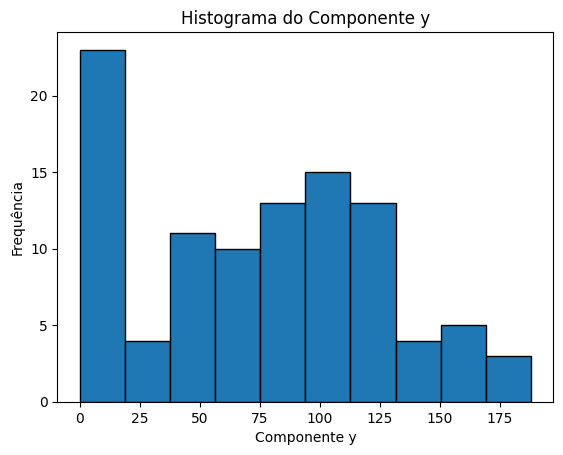

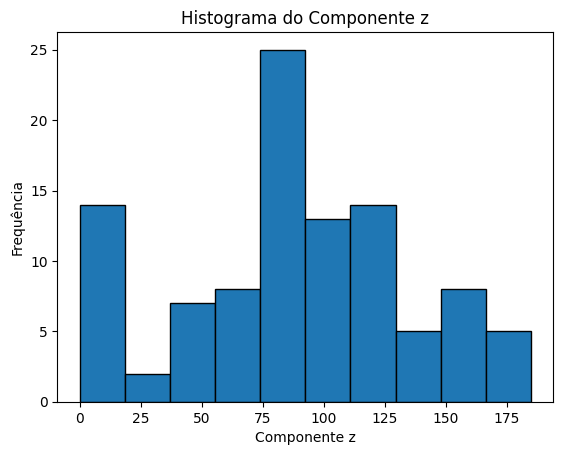

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.9994261198751154
Estados: (0.999330985624259-1.1115795784593307e-14j)
Distância: 3.2196781565761127e-06
 


In [21]:
portas = []
estados = []
distancia = []
i = 1

print(f"Começará a função principal")
fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
print(f"Terminou a função principal")
print(f"Veja o log: (Dos estados)")
print(fid_vector)
print(f"Veja o log: (Das portas)")
print(fid_autores)

portas.append(fid_autores[-1])
estados.append(fid_vector[-1])
distancia.append(distance_vector[-1])

print(f"Começou o histograma")
histograma(0, a)
histograma(1, a)
histograma(2, a)
print(f"Terminou o histograma")

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

In [22]:
fid_vector

[(0.5042478466284487-1.8078903405427336e-09j),
 (0.5716372231563115-6.852678157233086e-10j),
 (0.6802725970850254-6.498102153787078e-09j),
 (0.8207674666703659-1.2604773680894872e-08j),
 (0.9392894477986954+3.719205977925605e-09j),
 (0.9839199621519377+1.9606436233687637e-09j),
 (0.9945814380333109+1.7097265061054366e-09j),
 (0.9984101896892116+8.419891020994336e-10j),
 (0.999629822950282-7.677648892320873e-10j),
 (0.9999776053838633+6.630785940256165e-10j),
 (1.0000996996424254-5.435779105548642e-12j),
 (1.0001469728912264-1.4546138566379896e-11j),
 (1.0001705658715117-1.7186927107225663e-10j),
 (1.000175052928494+1.8630488825308477e-10j),
 (1.0001729855275918+1.7805392536475353e-13j),
 (1.000165699910691+4.485577650324736e-11j),
 (1.0001579000479854-3.93422558096637e-11j),
 (1.0001487474403497-1.1251056843447926e-12j),
 (1.0001392156753592+2.908490908047826e-12j),
 (1.0001294598095387-3.7688491784484844e-12j),
 (1.0001195311951405+2.959622963687837e-11j),
 (1.0001096156842735+1.51064

In [23]:
fid_autores

[0.3275986837092666,
 0.26752465197191644,
 0.2706900791167463,
 0.46698317040853016,
 0.7845300080176072,
 0.9416466466922113,
 0.9833279855596097,
 0.9954091036157289,
 0.9999715330766797,
 1.0010845294786774,
 1.0014368701554985,
 1.0015949186861473,
 1.0016597924907258,
 1.0016766031786808,
 1.0016718595512284,
 1.001654896483017,
 1.0016331315162335,
 1.0016091200075639,
 1.001583444944836,
 1.0015571811626776,
 1.0015306296005202,
 1.001504038613379,
 1.0014774072975354,
 1.0014507295971662,
 1.0014240456489187,
 1.0013973511069205,
 1.0013706604781556,
 1.001343963854554,
 1.001317265980931,
 1.0012905712627291,
 1.0012638759633752,
 1.0012371802958453,
 1.0012104863249438,
 1.0011837941628128,
 1.001157101619263,
 1.0011304104630079,
 1.0011037193080121,
 1.0010770274507588,
 1.001050339311826,
 1.0010236516775597,
 1.0009969642296968,
 1.0009702762560115,
 1.0009435893256604,
 1.0009169043450303,
 1.0008902193708975,
 1.0008635349041428,
 1.0008368525451454,
 1.000810170333365

In [24]:
rho_vector

array([[0.50424785+0.j        , 0.57163721+0.j        ,
        0.6802726 +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49403248-0.07686847j, 0.42678578-0.25031469j,
        0.30873065-0.34934661j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49403248+0.07686847j, 0.42678578+0.25031469j,
        0.30873065+0.34934661j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49575215+0.j        , 0.42836279+0.j        ,
        0.3197274 +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ]])

In [25]:
distance_vector

[7.929960672888765,
 6.918379472092127,
 4.997649243773367,
 2.768069949255776,
 0.9292096623636629,
 0.2440614216392343,
 0.0743011024396211,
 0.025712787673524844,
 0.007492817123933691,
 0.002958915495132875,
 0.0014455351784499412,
 0.0007078464403223982,
 0.0003422121299085298,
 0.00016838503492392742,
 8.065016047578122e-05,
 4.168798641411228e-05,
 2.1905678461065633e-05,
 1.1117542370366357e-05,
 6.952005814384588e-06,
 5.140501543227426e-06,
 4.482079951878666e-06,
 3.9857613934373e-06,
 3.6555603575592953e-06,
 3.513977917412793e-06,
 3.4017574789467638e-06,
 3.3360063197465326e-06,
 3.258993815860144e-06,
 3.2100910565122548e-06,
 3.1704394728639285e-06,
 3.122463762901059e-06,
 3.0810578603254877e-06,
 3.0454013129179683e-06,
 3.0072078025704398e-06,
 2.9661295937408586e-06,
 2.9308276292690644e-06,
 2.894190312411935e-06,
 2.8618215862004423e-06,
 2.8365221310414066e-06,
 2.8006723429175798e-06,
 2.7670420453920537e-06,
 2.7369139049578067e-06,
 2.713192845794627e-06,
 2.6

In [26]:
fx_vector

[110.18978141737604,
 400,
 400,
 400,
 400,
 153.65390545359423,
 75.52955375706996,
 46.04916482892904,
 26.006066929294057,
 13.996603018260606,
 6.9280950050706025,
 2.2158744594178192,
 2.6060618769638335,
 2.375877600997955,
 1.588216466872273,
 0.6883321471284413,
 0.6657753614649452,
 0.36276802030673694,
 0.3410465445442527,
 0.1847607138922476,
 0.11467724973282141,
 0.05612957468985848,
 0.094322887143384,
 0.021978363669083248,
 0.015608913504198879,
 0.02223526483238572,
 0.014076600583269608,
 -0.005024050851043092,
 0.0069751157443316905,
 0.0011609926783518673,
 0.004769140790731569,
 -0.005238235678465358,
 -0.001394223629045576,
 -0.004277868210770194,
 0.009572138054497185,
 0.0004080875275570134,
 -0.0010981685064336034,
 0.0032022181357168056,
 -0.006346883069038179,
 0.007923406406291161,
 0.0034816842914684384,
 -0.010265546110298424,
 0.006851088271095922,
 0.004921846357918307,
 -0.009183909277318778,
 0.007233188817911813,
 -0.004807985783812252,
 0.0053808700

In [27]:
fy_vector

[9.329184316622891e-06,
 -0.06830770345215666,
 42.724542369316815,
 5.1019241809198475,
 0.01486673032683516,
 0.008697856577101733,
 0.013105841859397723,
 0.0008266102873271504,
 0.01164796589414798,
 0.2691731938845042,
 4.133589044346522,
 4.648252990959304,
 3.071716519413828,
 1.1330545821907452,
 1.1624434333198364,
 0.7280069253726286,
 0.7331278168925357,
 0.42200970275593935,
 0.25161171515622177,
 0.19748525139276463,
 0.06107381187442394,
 0.10497395133587213,
 0.06262636980568109,
 0.030280014885080538,
 0.02419472108388647,
 0.004129905511130249,
 0.01365056665820158,
 0.005140384835020405,
 -0.013552251202458286,
 0.011396779492818719,
 0.001186928943126192,
 -0.0068928514894884205,
 0.001740017953323153,
 0.00914655321352184,
 -0.008679422624795024,
 0.001839720646591561,
 0.005950286518481673,
 -0.01315659611271169,
 0.01064146888613086,
 -0.0019153471908608735,
 0.0004402331444180625,
 0.0066955269830879655,
 -0.003516292871003253,
 -0.00503608394575563,
 0.007712132

In [28]:
fz_vector

[154.66812923497776,
 400,
 400,
 400,
 376.0343156989409,
 147.49756314731636,
 75.683059755606,
 35.51658762634648,
 24.125456728410274,
 10.984813689377793,
 5.195281239488137,
 4.377364862741166,
 2.4774466148402725,
 1.9234845687990758,
 1.2637550754071085,
 1.1582656819484094,
 0.4870257964690707,
 0.6253740071121903,
 0.28183210267218156,
 0.17853405069486208,
 0.1036659560967779,
 0.0932810114452209,
 0.03702211040562792,
 0.04227845278138067,
 0.03399435925539587,
 -0.0005376902358461208,
 0.014204017988762377,
 0.008258644621921649,
 0.0010072085997456098,
 -0.0012262977470306122,
 -0.002721794574791443,
 0.006891987137919553,
 0.003025067451976185,
 0.0015895078519505834,
 -0.0033256641744009996,
 0.004668587955645995,
 -0.0035374455226319344,
 -0.0017581041087428896,
 0.0049908166600914385,
 0.0032140486065037714,
 0.002752752952201086,
 -0.0035035083627188122,
 -0.00632115689770622,
 0.0066766611381247135,
 0.0016643442442975456,
 0.0015191059623720221,
 0.0040735622259618

In [29]:
a

[(110.18978141737604, 9.329184316622891e-06, 154.66812923497776),
 (134.02154844642286, 0.0006710523318310033, 155.22779768404226),
 (35.62656573085123, 25.972029781968473, 53.91841936670511),
 (65.87746472062359, 5.540676759932609, 72.72693714014997),
 (154.68569372531945, 0.0, 139.9761283810183),
 (140.45522653338085, 0.0018316163359520495, 143.950578977149),
 (126.27486324300472, 0.11774121573258625, 162.74739232028617),
 (143.01756523463902, 0.0, 119.7143294542805),
 (154.80015502438704, 0.13572173713066712, 178.58818888829325),
 (159.49482295213483, 3.209538497124149, 124.85522870455051),
 (127.16306867800517, 63.93351841071874, 79.96810713033923),
 (48.2549648402943, 115.79256050801192, 102.43905320827588),
 (77.65595869727558, 129.83760648624263, 79.22307387776632),
 (112.18049349323137, 59.39851176474317, 87.40292223346077),
 (124.01832933172506, 86.620405402453, 78.51042403832024),
 (69.95484678546235, 72.29870291962564, 115.88000763899579),
 (103.0265897820276, 119.1708799354